In [1]:
import numpy as np
import xarray as xr
import xarray.ufuncs as xfun
import sys
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cm_xml_to_matplotlib as cm # Note: this python script must be located in the same folder as the current script
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os

# Setup and Import

In [2]:
# Setup strings that will be concatenated together to form the path to the file

# List all the hindcast days to be loaded. Note, if this changes it could break other parts of the script.
# Note that the first index is zero as there is no hindcast day 0.
hcastDayStr = [None,'01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
hcastDay = [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# These are the base strings of the hindcast file paths/names
dri = '/lss/research/agon-lab/CAM_hindcasts/tratl_cam5.3_ne30_rneale.globe/' # used for Hadley computer
fn = 'tratl_cam5.3_ne30_rneale.globe.fcast.day'

# Initialize variables to hold raw data. They are the length of the previously defined strings. 
dataImportTS  = [None] * len(hcastDayStr)
dataImportPSL = [None] * len(hcastDayStr)
dataImportQ   = [None] * len(hcastDayStr)

# Create a loading progress bar
print('Starting import. \nImporting hindcast day:', end=' ')

# Using the initialized strings and empty variables, load each dataset
for ii, day in enumerate(hcastDayStr):
    if ii == 0: continue # Skip zero index so that the hindcast indexing is more intuitive 
                         # (e.g. day 7 hindcast is indexed with a 7)
            
    # Create a "progress bar"
    print(ii, end=' ')
    
    # Open the datasets with Xarray
    dataImportTS[ii]  = xr.open_dataset(dri+fn+day+'.TS.nc' )
    dataImportPSL[ii] = xr.open_dataset(dri+fn+day+'.PSL.nc')
    dataImportQ[ii]   = xr.open_dataset(dri+fn+day+'.QREFHT.nc')
    
    # Convert the time stamps from the cf convention to the np.datetime64 convention
    # This is done as the datetime64 convention is more easily manipulated and indexed compared to the cf convention
    dataImportTS[ii]['time']  = dataImportTS[ ii].indexes['time'].to_datetimeindex(unsafe=True)
    dataImportPSL[ii]['time'] = dataImportPSL[ii].indexes['time'].to_datetimeindex(unsafe=True)
    dataImportQ[ii]['time']   = dataImportQ[  ii].indexes['time'].to_datetimeindex(unsafe=True)


## ERA5 mean sea level pressure
print('\nImporting ERA5: MSLP', end='...')
driERA5 = '/lss/research/agon-lab/ERA5_ITCZ/' # The path to all ERA5 files
fnMslpObs  = 'mslp/mslp_1979-2019_daily.nc'
dataImportPSLObs = xr.open_dataset(driERA5+fnMslpObs)
# Reverse the latitude on all ERA5 data so that it matches the hindcast convention (south->north)
dataImportPSLObs = dataImportPSLObs.reindex(latitude=dataImportPSLObs['latitude'][::-1])

## ERA5 2 meter temperature
print('ta', end='...')
fnTaObs  = 'ta/t2m_1979-2019_daily.nc'
dataImportTaObs = xr.open_dataset(driERA5+fnTaObs)
dataImportTaObs = dataImportTaObs.reindex(latitude=dataImportTaObs['latitude'][::-1])

# ERA5 land-sea mask
print('mask', end='...')
fnMaskObs  = 'lsm_era5.nc'
dataMaskObs = xr.open_dataset(driERA5+fnMaskObs)
dataMaskObs = dataMaskObs.reindex(latitude=dataMaskObs['latitude'][::-1])

# ERA5 specific humidity
print('specific humidity', end='...')
fnQObs = '/shumidity/q2m_1979-2019_daily.nc'
dataImportQObs = xr.open_dataset(driERA5+fnQObs)

print('import complete!')

Starting import. 
Importing hindcast day: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Importing ERA5: MSLP...ta...mask...specific humidity...import complete!


# User Inputs Go Here

In [3]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************

#### Select the date in 'YYYY-MM-DD' format (ISO 8601) ####
_dayOfTheSeason = '2010-02-23'

#### Select the number of days to be time averaged AKA event duration ####
numDayAvg = 6

# Choose region of interest 
lats = -20
latn =  20
lonw = -135 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90  


# ************************************************************************************************
# *************************** User inputs no longer required *************************************
# ************************************************************************************************

# Convert _dayOfTheSeason to datetime64 format
dayOfTheSeason = np.datetime64(_dayOfTheSeason)

#### Select the data within the user defined region of interest

In [4]:
# First, check if the user has requested data that is out of the time bounds of hindcast dataset. If so, intentionally break the code
# Note, it's possible this check might not work more years of hindcast data are added.
# If this happens, just comment this out and be careful not to over extend the bounds as Python might not raise an error
if dayOfTheSeason+numDayAvg-1 > dataImportPSL[1]['time'][-1] or dayOfTheSeason < dataImportPSL[-1]['time'][0]:
    sys.exit("You attemped to access data that is outside of the time bounds of the hindcast dataset :(")
else: # if the check passes, run the correct operational code
    # Initialize empty arrays to contain the refined imported data
    selTS  = [None] * len(hcastDayStr)
    selPSL = [None] * len(hcastDayStr)
    selQ   = [None] * len(hcastDayStr)

# Increase the region of interest for interpolation purposes
_latn = latn+2; _lats = lats-2
_lonw = lonw-2; _lone = lone+2

# Iterate through each hindcast day and select the data in the region of interest.
# In the same step, take a temporal average over the user specified numDayAvg.
# The iteration starts at 1 to agree with the indexing convention of the hindcast days (starting with 1)
for ii in range(1, len(hcastDayStr)):
    # Use isel to exclude the first time index. 
    # This is due to the hindcast time stamps representing the data three hours prior. Thus, the 00:00:00 represents the day prior from 9PM-12
    # Add 360 to the longitude so that it agrees with the hindcast dataset lon convention (0-360)
    selTS[ii]  = dataImportTS[ ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                                       lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                        ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)
    selPSL[ii] = dataImportPSL[ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                                       lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                        ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)
    selQ[ii]   = dataImportQ[  ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg),
                                       lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                        ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)

# Do the same for the obs
selPSLObs=dataImportPSLObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                               latitude=slice(_lats, _latn), 
                               longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)
selTaObs = dataImportTaObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg),
                               latitude=slice(_lats, _latn), 
                               longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)
selQObs  =  dataImportQObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg),
                               latitude=slice(_lats, _latn), 
                               longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)

# For the mask, use the user specified region of interest as the mask is not invlolved in the interpolation 
selMaskObs = dataMaskObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360, lone+360))

#### Prepare the data to be plotted

In [5]:
# Prepare the mask. Ceiling the data so that the land location is over estimated
plotMaskObs = xfun.ceil(selMaskObs.mean(dim='time', keep_attrs=True)['lsm'])

# Initialize lists for final, plottable hindcast data
plotTS  = [None] * len(selTS)
plotPSL = [None] * len(selPSL)
plotQ   = [None] * len(selQ)

# Interpolate the hindcast dataset to the ERA5 spatial resolution. 
# This is done so that it can masked with the ERA5 mask and so that error plots can be generated
for ii in range(1,len(hcastDay)):
    # Set fill value argument to none so that the interpolation function will also extrapolate
    plotPSL[ii] = selPSL[ii].interp({'lat':selPSLObs['latitude' ].values, 
                                     'lon':selPSLObs['longitude'].values}, kwargs={"fill_value":None})
    plotTS[ii]  = selTS[ ii].interp({'lat':selPSLObs['latitude' ].values, 
                                     'lon':selPSLObs['longitude'].values}, kwargs={"fill_value":None})
    plotQ[ii]   = selQ[  ii].interp({'lat':selPSLObs['latitude' ].values,
                                     'lon':selPSLObs['longitude'].values}, kwargs={"fill_value":None})
    
    # Cut off the end points of the interpolated dataset. This refines the dataset back down to the user specified region of interest.
    plotPSL[ii] = plotPSL[ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    plotTS[ ii] = plotTS[ ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    plotQ[  ii] = plotQ[  ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    
    # Convert the units from Pa to hPa
    plotPSL[ii] = plotPSL[ii]/100
    plotPSL[ii]['PSL'].attrs['units'] = 'hPa'
    
    # Add a land-sea mask to the datasets
    plotPSL[ii].coords['mask'] = (('lat', 'lon'), plotMaskObs)
    
    
# Create multi-day averages. This is done by....
# Convert the plotVARIABLE list into a numPy array (that stores objects). Iterate over 5 day periods. Take an average of that 5 day period. 
# Store each of these averages in a list as ii iterates in range(1,20,5).
plotPSLMultiDay = [np.array(plotPSL, dtype=object)[ii:ii+5].mean() for ii in range(1,len(hcastDayStr),5)]
plotTSMultiDay  = [np.array(plotTS,  dtype=object)[ii:ii+5].mean() for ii in range(1,len(hcastDayStr),5)]
plotQMultiDay   = [np.array(plotQ,   dtype=object)[ii:ii+5].mean() for ii in range(1,len(hcastDayStr),5)]
    
# Do the same for obs. 
# Refine the dataset to the user specified region of interest
plotPSLObs = selPSLObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360, lone+360))
plotTaObs  =  selTaObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360, lone+360))
plotQObs   =   selQObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360, lone+360))

# Convert the data from Pa to hPa
plotPSLObs = plotPSLObs/100
plotPSLObs['msl'].attrs['units'] = 'hPa'

# Add a land-sea mask to the dataset
plotPSLObs.coords['mask'] = (('latitude', 'longitude'), plotMaskObs)

# PSL Plots

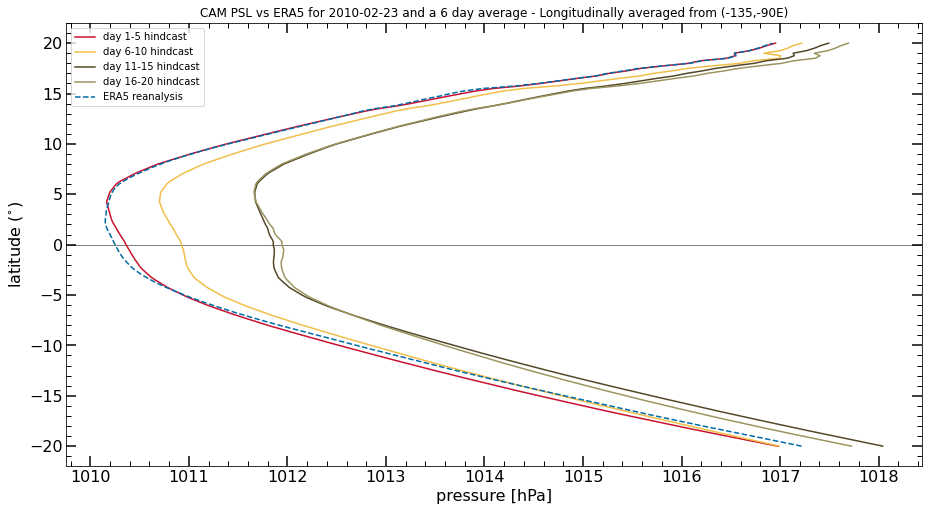

In [6]:
# Plot a comparison between hindcasts and observation

# Set pixel density of plot
_dpi = 100

# Setup the figure
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0', linewidth = 0.5, zorder=-1)
plt.ylabel('latitude $(^{\circ})$', fontsize=16)
plt.xlabel('pressure [hPa]', fontsize=16)
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#8B5B29', '#BE531C'] # Go Cyclones! :)
plotLegend = []

for ii in range(len(plotPSLMultiDay)):
    
    # Plot the hindcasts. Mask the land values. 
    p1 = plt.plot(plotPSLMultiDay[ii]['PSL'].where(plotPSLMultiDay[ii]['mask']==0).mean('lon'), 
                  plotPSLMultiDay[ii]['lat'], color = plotColors[ii], 
                  label = 'day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast') 

# Plot ERA5. Mask the land values. 
p2 = plt.plot(plotPSLObs['msl'].where(plotPSLObs['mask']==0).mean('longitude'), plotPSLObs['latitude'],  
              color='#006BA6', linestyle='dashed', label='ERA5 reanalysis')

plt.title("CAM PSL vs ERA5 for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+
          " day average - Longitudinally averaged from ("+str(lonw)+','+str(lone)+'E)')
plt.legend()

# # Save figure code
# # Check if folder is there. If it is not, make the folder
# dir = '/home/jlarson1/'+str(dayOfTheSeason)+' Analysis'
# if os.path.isdir(dir) == False:
#     os.mkdir(dir)

# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvg'+varName+'LinePlot', bbox_inches='tight', dpi=_dpi)
    
plt.show()

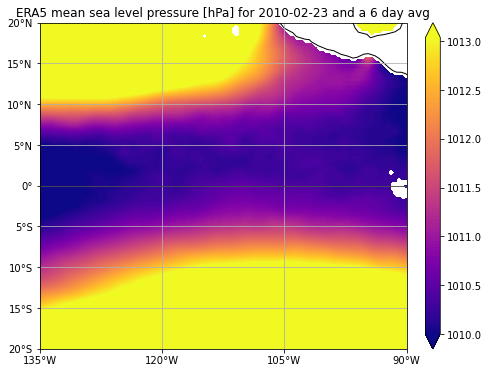

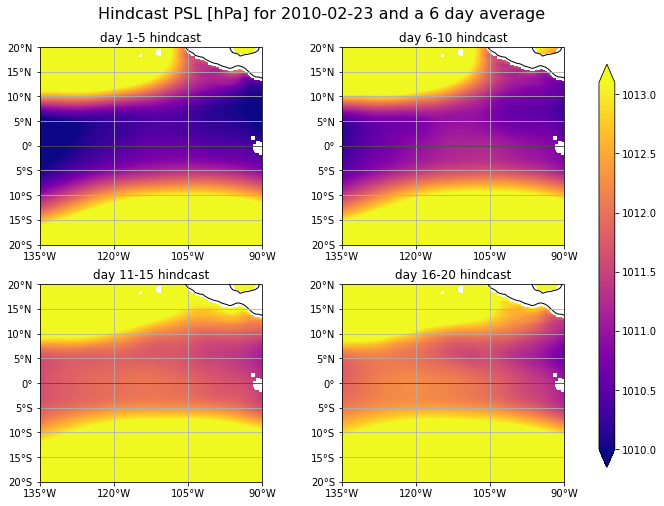

In [7]:
# Create a map plot of the observation data

##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 1013+.1
Vmin = 1010
dC = (Vmax-Vmin)/100

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 200

###########################################

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
# Use user specified lat values for tick marks
geo_axes.set_yticks(np.arange(lats, latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats, latn+1,5))
plt.axhline(0, color='0', linewidth = 0.5)
image_extent = [lonw,lone,lats,latn]

# Plot ERA5 PSL
IM = geo_axes.contourf(plotPSLObs['longitude'], plotPSLObs['latitude'], 
                       plotPSLObs['msl'].where(plotPSLObs['mask']==0), 
                       np.arange(Vmin, Vmax+dC-0.069, dC), transform=ccrs.PlateCarree(), cmap='plasma', extend='both')
                                        # ^^^ That 0.069 is to get the tick marks just right. It might need to be changed in the future

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, ticks=np.arange(Vmin,Vmax, 0.5))
plt.title("ERA5 mean sea level pressure [hPa] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day avg")
    
plt.show()

###########################################################################################

# Plot four subplots for each hindcast day

###########################################################################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Loop through the MultiDay lists to overlay multiple periods of hindcast data
for ii in range(len(plotPSLMultiDay)):
    
    # Plot PSL with land values masked
    im = axes.flat[ii].imshow(plotPSLMultiDay[ii]['PSL'].where(plotPSLMultiDay[ii]['mask']==0), 
                              extent=image_extent, origin='lower', cmap='plasma', vmax=Vmax, vmin=Vmin)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 0.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Hindcast PSL [hPa] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()

# Calculate PGA (both dry and moist)

In [8]:
# Calculate the pressure gradient

# Initialize lists for hindcast data
gradPSL = [None] * len(plotPSLMultiDay)

for ii in range(0, len(plotPSLMultiDay)):
    # Make sure pressure data is in Pa (convert from hPa)
    plotPSLMultiDay[ii]['PSL'] = plotPSLMultiDay[ii]['PSL']*100
    plotPSLMultiDay[ii]['PSL'].attrs['units'] = 'hPa'
    
    # Perform the gradient using NumPy
    # Future work: try to do this with MetPy as it works better with lat/lon grids.
    gradPSL[ii] = np.gradient(plotPSLMultiDay[ii]['PSL'].values, 
                              plotPSLMultiDay[ii]['lat'], plotPSLMultiDay[ii]['lon'])

# Make sure ERA5 pressure data is in Pa (convert from hPa)
plotPSLObs['msl'] = plotPSLObs['msl']*100
plotPSLObs['msl'].attrs['units'] = 'hPa'

# Perform the gradient using NumPy
gradPSLObs = np.gradient(plotPSLObs['msl'].values, 
                         plotPSLObs['latitude'], plotPSLObs['longitude'])

In [9]:
# Calculate the density, virtual temperature and PGA

# Define gas constants for both dry air (Rd) and water vapor (Rv)
Rv = 461 # J/(K*kg)
Rd = 287 # J/(K*kg)

# Initialize arrays to hold data 
dataRho  = [None] * len(plotPSLMultiDay)
dataRhov = [None] * len(plotPSLMultiDay)
dataPGA  = [None] * len(plotPSLMultiDay)
dataPGAv = [None] * len(plotPSLMultiDay)
dataTv   = [None] * len(plotPSLMultiDay)

# ideal gas law (dry) p = rho*R*T -> rho = p/(R*T)
for ii in range(len(plotPSLMultiDay)): 
    
    # Determine CAM virutal temperature using specific humidity
    dataTv[ii]   = plotTSMultiDay[ii]['TS']*(1 + ( (Rv/Rd) -1)*plotQMultiDay[ii]['QREFHT'] )
    
    # Determine dry and moist density
    dataRho[ii]  = plotPSLMultiDay[ii]['PSL']/(Rd*plotTSMultiDay[ii]['TS'])
    dataRhov[ii] = plotPSLMultiDay[ii]['PSL']/(Rd*dataTv[ii])
    
    # Determine dry and moist PGA
    dataPGA[ii]  = (-gradPSL[ii][0]/dataRho[ii] )*3600*24/111320
    dataPGAv[ii] = (-gradPSL[ii][0]/dataRhov[ii])*3600*24/111320 # convert from degrees lat/lon to meters
    # for the gradient, the 0 index is dy and the 1 index is dx
    
# Do the same for obs
dataTvObs = plotTaObs['t2m']*(1 + ( (Rv/Rd) -1)*plotQObs['q2m'] )

dataRhoObs  = plotPSLObs['msl']/(Rd*plotTaObs['t2m'])
dataRhovObs = plotPSLObs['msl']/(Rd*dataTvObs)

dataPGAObs  = (-gradPSLObs[0]/dataRhoObs )*3600*24/111320 # convert from deg lat/lon to meters
dataPGAvObs = (-gradPSLObs[0]/dataRhovObs)*3600*24/111320

# PGA Plots

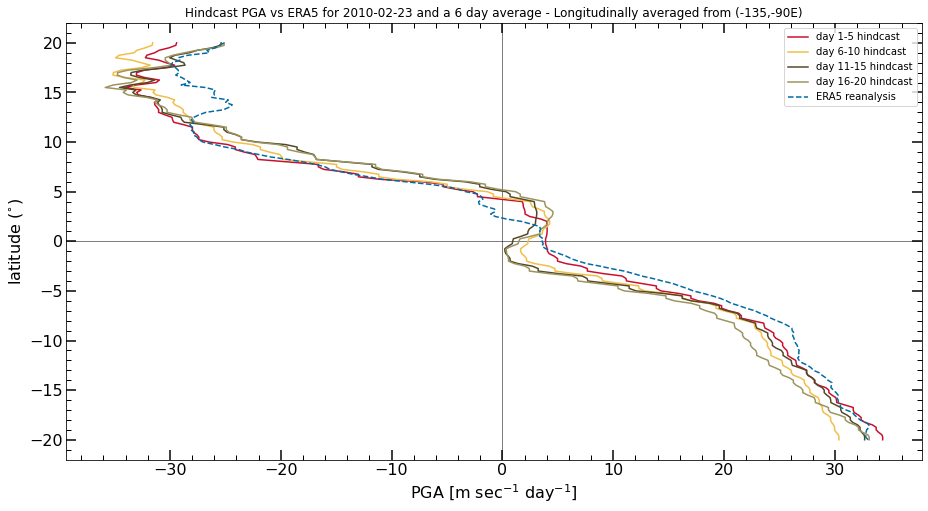

In [10]:
# Plot a comparison between hindcasts and observation

# Set pixel density of plot
_dpi = 100

# Setup the figure
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0', linewidth = 0.5, zorder=-1)
plt.axvline(0, color='0', linewidth = 0.5, zorder=-1)
plt.ylabel('latitude $(^{\circ})$', fontsize=16)
plt.xlabel('PGA [m sec$^{-1}$ day$^{-1}$]', fontsize=16)
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#8B5B29', '#BE531C'] # Go Cyclones! :)
plotLegend = []

# Loop through the MultiDay lists to overlay multiple periods of hindcast data
for ii in range(len(plotPSLMultiDay)):
    
    # Plot the hindcasts. Map the land values
    p1 = plt.plot(dataPGAv[ii].where(dataPGAv[ii]['mask']==0).mean('lon'), dataPGAv[ii]['lat'], 
                  color=plotColors[ii], label='day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    
# Plot ERA5
p2 = plt.plot(dataPGAvObs.where(dataPGAvObs['mask']==0).mean('longitude'), dataPGAvObs['latitude'],  
              color='#006BA6', linestyle='dashed', label='ERA5 reanalysis')
plt.title("Hindcast PGA vs ERA5 for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+
          " day average - Longitudinally averaged from ("+str(lonw)+','+str(lone)+'E)')
plt.legend()

# # Save figure code
# # Check if folder is there. If it is not, make the folder
# dir = '/home/jlarson1/'+str(dayOfTheSeason)+' Analysis'
# if os.path.isdir(dir) == False:
#     os.mkdir(dir)

# plt.savefig(dir+'/'+'PGA_linePLot_'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvg', bbox_inches='tight', dpi=_dpi)
    
plt.show()

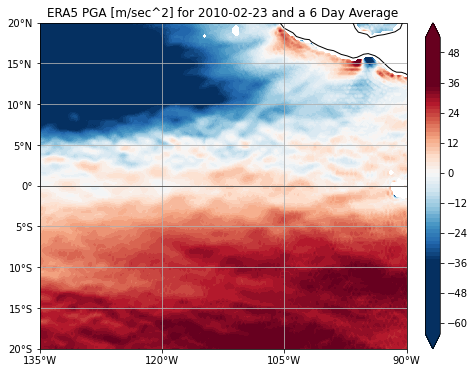

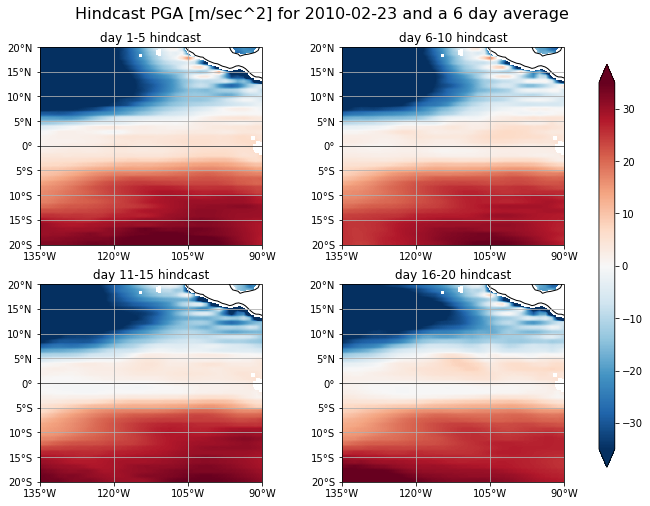

In [11]:
# Create a map plot of the observation data

##### Control plotting variables here #####

# Set maximum of colorbar [mm/day]
Vmax = 35

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 200

###########################################

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats, latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats, latn+1,5))
plt.axhline(0, color='0', linewidth = 0.5)
image_extent = [lonw,lone,lats,latn]

# Plot ERA5 contour plot. Mask land values
IM = geo_axes.contourf(dataPGAvObs.longitude, dataPGAvObs.latitude, dataPGAvObs.where(dataPGAvObs['mask']==0), 
                       transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both', levels=100, vmax=Vmax, vmin=-Vmax) 

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02)
plt.title("ERA5 PGA [m/sec^2] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
    
plt.show()


#############################################################################################
#                                  Plot subplots for CAM
#############################################################################################


# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))


# Iterate through the subplots
for ii in range(len(plotPSLMultiDay)):

    im = axes.flat[ii].imshow(dataPGAv[ii].where(dataPGAv[ii]['mask']==0), extent=image_extent, origin='lower', 
                              interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn])
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 0.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Hindcast PGA [m/sec^2] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()

# PGA Absolute Error

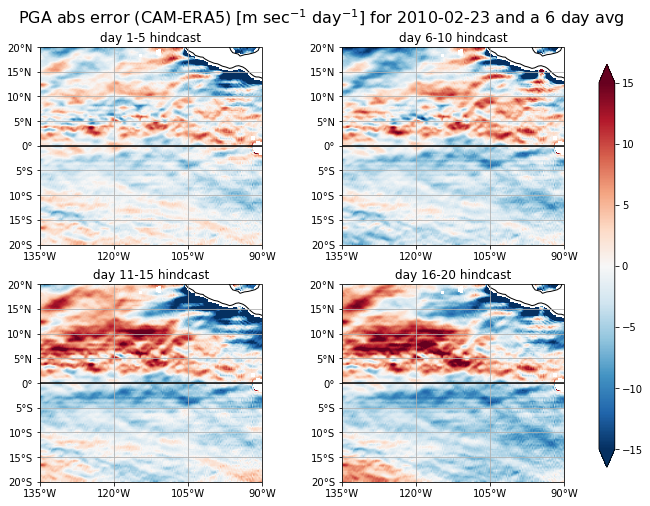

In [12]:
##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 15

###########################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Iterate through the subplots
for ii in range(len(dataPGAv)):

    # Plot the difference of CAM - ERA5
    im = axes.flat[ii].imshow(dataPGAv[ii].where(dataPGAv[ii]['mask']==0).values-dataPGAvObs.values, extent=image_extent, origin='lower', 
                              interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values 
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("PGA abs error (CAM-ERA5) [m sec$^{-1}$ day$^{-1}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day avg",
             size=16,y=0.95)

# # Save figure code    
# plt.savefig(dir+'/'+'PGA_ErrMap_'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvg', dpi=_dpi, bbox_inches='tight')

plt.show()

## Comparison of dry to moist results

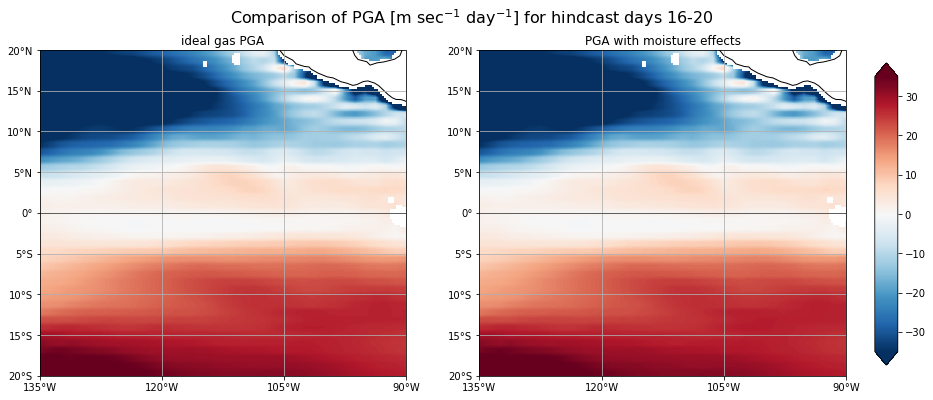

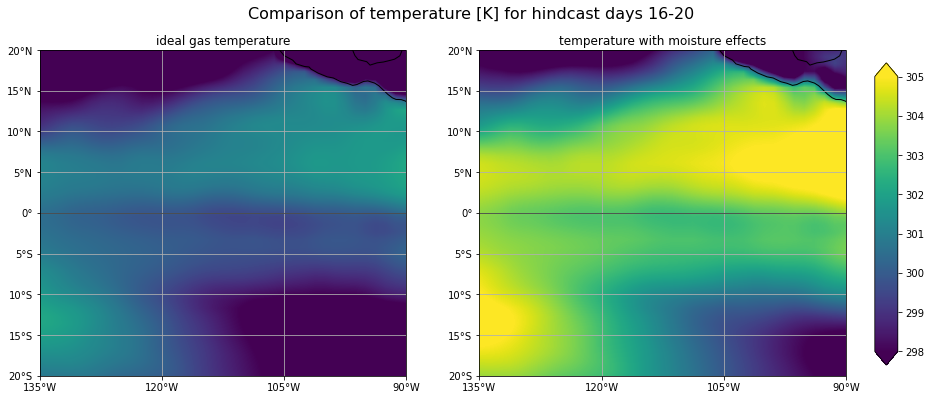

In [13]:
# Set maximum of colorbar
Vmax = 35

fig, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))


im = axes2.flat[0].imshow(dataPGA[3].where(dataPGA[3]['mask']==0), extent=image_extent, origin='lower', 
                          interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)


# Set boundaries of graphs
axes2.flat[0].set_xlim([lonw,lone])
axes2.flat[0].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes2.flat[0].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes2.flat[0].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes2.flat[0].xaxis.set_major_formatter(lon_formatter)
axes2.flat[0].yaxis.set_major_formatter(lat_formatter)
axes2.flat[0].coastlines(resolution='110m')
axes2.flat[0].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes2.flat[0].title.set_text('ideal gas PGA')
axes2.flat[0].axhline(0, color='0', linewidth = 0.5)

#############################################################################################
#############################################################################################


im = axes2.flat[1].imshow(dataPGAv[3].where(dataPGAv[3]['mask']==0), extent=image_extent, origin='lower', 
                          interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)


# Set boundaries of graphs
axes2.flat[1].set_xlim([lonw,lone])
axes2.flat[1].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes2.flat[1].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes2.flat[1].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes2.flat[1].xaxis.set_major_formatter(lon_formatter)
axes2.flat[1].yaxis.set_major_formatter(lat_formatter)
axes2.flat[1].coastlines(resolution='110m')
axes2.flat[1].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes2.flat[1].title.set_text('PGA with moisture effects')
axes2.flat[1].axhline(0, color='0', linewidth = 0.5)

plt.suptitle('Comparison of PGA [m sec$^{-1}$ day$^{-1}$] for hindcast days 16-20', size=16)
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')
plt.show()

#############################################################################################
#############################################################################################
#                            Moisture effects on temperature                                #
#############################################################################################
#############################################################################################

# Set maximum of colorbar
Vmax = 305
Vmin = 298

fig, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))


im = axes3.flat[0].imshow(plotTSMultiDay[3]['TS'], extent=image_extent, origin='lower', 
                          interpolation='bilinear', vmax=Vmax, vmin=Vmin)


# Set boundaries of graphs
axes3.flat[0].set_xlim([lonw,lone])
axes3.flat[0].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes3.flat[0].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes3.flat[0].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes3.flat[0].xaxis.set_major_formatter(lon_formatter)
axes3.flat[0].yaxis.set_major_formatter(lat_formatter)
axes3.flat[0].coastlines(resolution='110m')
axes3.flat[0].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes3.flat[0].title.set_text('ideal gas temperature')
axes3.flat[0].axhline(0, color='0', linewidth = 0.5)

#############################################################################################
#############################################################################################


im = axes3.flat[1].imshow(dataTv[3], extent=image_extent, origin='lower', 
                          interpolation='bilinear', vmax=Vmax, vmin=Vmin)


# Set boundaries of graphs
axes3.flat[1].set_xlim([lonw,lone])
axes3.flat[1].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes3.flat[1].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes3.flat[1].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes3.flat[1].xaxis.set_major_formatter(lon_formatter)
axes3.flat[1].yaxis.set_major_formatter(lat_formatter)
axes3.flat[1].coastlines(resolution='110m')
axes3.flat[1].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes3.flat[1].title.set_text('temperature with moisture effects')
axes3.flat[1].axhline(0, color='0', linewidth = 0.5)

plt.suptitle('Comparison of temperature [K] for hindcast days 16-20', size=16)
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')
plt.show()

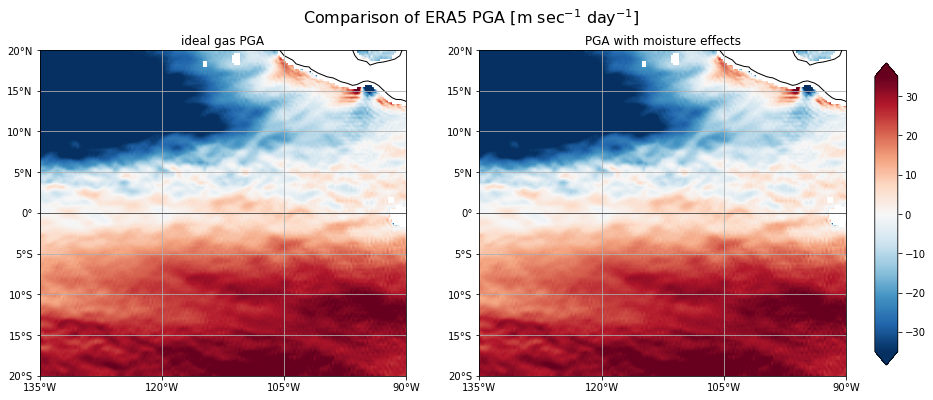

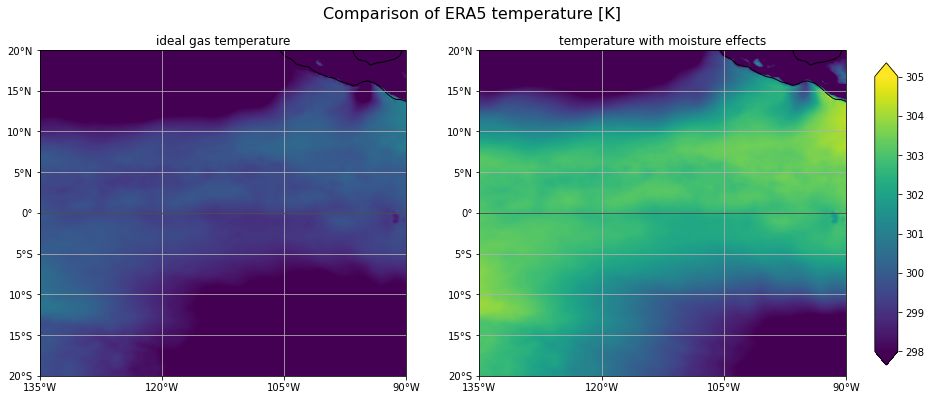

In [14]:
# Set maximum of colorbar
Vmax = 35

fig, axes4 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

im = axes4.flat[0].imshow(dataPGAObs.where(dataPGAObs['mask']==0), extent=image_extent, origin='lower', 
                          interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)

# Set boundaries of graphs
axes4.flat[0].set_xlim([lonw,lone])
axes4.flat[0].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes4.flat[0].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes4.flat[0].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes4.flat[0].xaxis.set_major_formatter(lon_formatter)
axes4.flat[0].yaxis.set_major_formatter(lat_formatter)
axes4.flat[0].coastlines(resolution='110m')
axes4.flat[0].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes4.flat[0].title.set_text('ideal gas PGA')
axes4.flat[0].axhline(0, color='0', linewidth = 0.5)

#############################################################################################
#############################################################################################

im = axes4.flat[1].imshow(dataPGAvObs.where(dataPGAvObs['mask']==0), extent=image_extent, origin='lower', 
                          interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)

# Set boundaries of graphs
axes4.flat[1].set_xlim([lonw,lone])
axes4.flat[1].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes4.flat[1].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes4.flat[1].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes4.flat[1].xaxis.set_major_formatter(lon_formatter)
axes4.flat[1].yaxis.set_major_formatter(lat_formatter)
axes4.flat[1].coastlines(resolution='110m')
axes4.flat[1].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes4.flat[1].title.set_text('PGA with moisture effects')
axes4.flat[1].axhline(0, color='0', linewidth = 0.5)

plt.suptitle('Comparison of ERA5 PGA [m sec$^{-1}$ day$^{-1}$]', size=16)
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')
plt.show()

#############################################################################################
#############################################################################################
#                            Moisture effects on temperature                                #
#############################################################################################
#############################################################################################

# Set maximum of colorbar
Vmax = 305
Vmin = 298

fig, axes5 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

im = axes5.flat[0].imshow(plotTaObs['t2m'], extent=image_extent, origin='lower', 
                          interpolation='bilinear', vmax=Vmax, vmin=Vmin)

# Set boundaries of graphs
axes5.flat[0].set_xlim([lonw,lone])
axes5.flat[0].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes5.flat[0].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes5.flat[0].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes5.flat[0].xaxis.set_major_formatter(lon_formatter)
axes5.flat[0].yaxis.set_major_formatter(lat_formatter)
axes5.flat[0].coastlines(resolution='110m')
axes5.flat[0].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes5.flat[0].title.set_text('ideal gas temperature')
axes5.flat[0].axhline(0, color='0', linewidth = 0.5)

#############################################################################################
#############################################################################################

im = axes5.flat[1].imshow(dataTvObs, extent=image_extent, origin='lower', 
                          interpolation='bilinear', vmax=Vmax, vmin=Vmin)

# Set boundaries of graphs
axes5.flat[1].set_xlim([lonw,lone])
axes5.flat[1].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes5.flat[1].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes5.flat[1].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes5.flat[1].xaxis.set_major_formatter(lon_formatter)
axes5.flat[1].yaxis.set_major_formatter(lat_formatter)
axes5.flat[1].coastlines(resolution='110m')
axes5.flat[1].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes5.flat[1].title.set_text('temperature with moisture effects')
axes5.flat[1].axhline(0, color='0', linewidth = 0.5)

plt.suptitle('Comparison of ERA5 temperature [K]', size=16)
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')
plt.show()

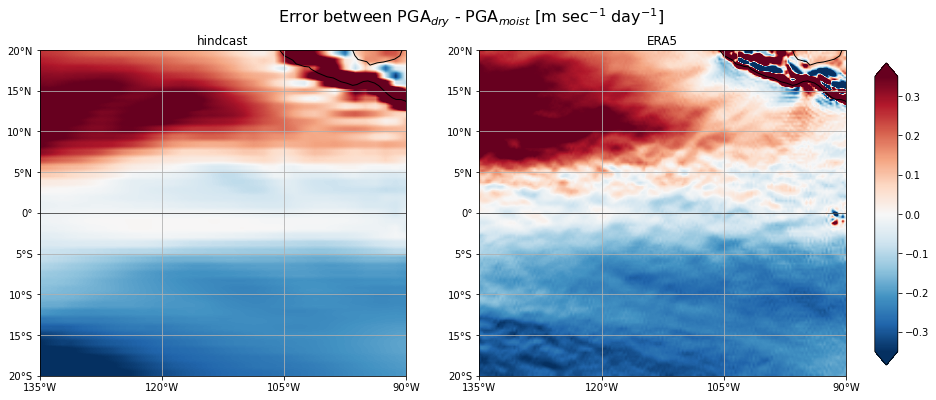

In [15]:
# Set maximum of colorbar
Vmax = 35/100

fig, axes4 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

im = axes4.flat[0].imshow(dataPGA[3]-dataPGAv[3], extent=image_extent, origin='lower', 
                          interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)

# Set boundaries of graphs
axes4.flat[0].set_xlim([lonw,lone])
axes4.flat[0].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes4.flat[0].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes4.flat[0].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes4.flat[0].xaxis.set_major_formatter(lon_formatter)
axes4.flat[0].yaxis.set_major_formatter(lat_formatter)
axes4.flat[0].coastlines(resolution='110m')
axes4.flat[0].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes4.flat[0].title.set_text('hindcast')
axes4.flat[0].axhline(0, color='0', linewidth = 0.5)

#############################################################################################
#############################################################################################

im = axes4.flat[1].imshow(dataPGAObs-dataPGAvObs, extent=image_extent, origin='lower', 
                          interpolation='bilinear', cmap='RdBu_r', vmax=Vmax, vmin=-Vmax)

# Set boundaries of graphs
axes4.flat[1].set_xlim([lonw,lone])
axes4.flat[1].set_ylim([lats,latn]) # Use user specified lat values 

# Set asthetic constraints of the plot
axes4.flat[1].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
axes4.flat[1].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axes4.flat[1].xaxis.set_major_formatter(lon_formatter)
axes4.flat[1].yaxis.set_major_formatter(lat_formatter)
axes4.flat[1].coastlines(resolution='110m')
axes4.flat[1].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
axes4.flat[1].title.set_text('ERA5')
axes4.flat[1].axhline(0, color='0', linewidth = 0.5)

plt.suptitle('Error between PGA$_{dry}$ - PGA$_{moist}$ [m sec$^{-1}$ day$^{-1}$]', size=16)
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. 
# Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')
plt.show()